# Обучение представлений и глубокое обучение, Домашнее задание 1
## Классификация китайских иероглифов
### https://inclass.kaggle.com/c/rdl-classification-challenge

### Кашин Андрей, ШАД, Computer Science 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys

# Make sure that caffe is on the python path:
caffe_root = os.environ["CAFFE_ROOT"]  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, os.path.join(caffe_root, "python"))

import caffe
import pandas as pd
import matplotlib.pyplot as plt
import scipy

#### Фкнции для загрузки данных

In [3]:
def load_data(path, num_samples=None):
    samples = []
    samples_processed = 0
    with open(path, "r") as f:
        while True:
            try:
                image = np.load(f)
                samples.append(image)
                samples_processed += 1
            except Exception, e:
                break
            if samples_processed % 10000 == 0:
                print("Processed: {}".format(samples_processed))
            if num_samples and samples_processed >= num_samples:
                break
    return samples

def load_labels(path, num_samples=None):
    labels = pd.read_csv(path)
    if num_samples:
        return labels["Prediction"].values[:num_samples]
    else:
        return labels["Prediction"].values

### Загружаем данные

In [4]:
num_samples = None

X = load_data("./data/Train/data.bin", num_samples)
X_test = load_data("./data/Test/data.bin", num_samples)
y_orig = load_labels("./data/Train/train.csv", num_samples)

print("Data size: {}".format(len(X)))
print("Labels size: {}".format(len(y_orig)))

Processed: 10000
Processed: 20000
Processed: 30000
Processed: 40000
Processed: 50000
Processed: 60000
Processed: 70000
Processed: 80000
Processed: 90000
Processed: 100000
Processed: 110000
Processed: 120000
Processed: 130000
Processed: 140000
Processed: 150000
Processed: 160000
Processed: 170000
Processed: 180000
Processed: 190000
Processed: 200000
Processed: 10000
Processed: 20000
Processed: 30000
Processed: 40000
Processed: 50000
Processed: 60000
Processed: 70000
Processed: 80000
Processed: 90000
Processed: 100000
Processed: 110000
Processed: 120000
Processed: 130000
Processed: 140000
Processed: 150000
Processed: 160000
Processed: 170000
Processed: 180000
Processed: 190000
Processed: 200000
Data size: 200000
Labels size: 200000


### Масштабируем все картинки до одинакового размера

In [5]:
h = 50
w = 50

Xr = np.array([scipy.misc.imresize(x, (h, w)).reshape((1, h, w)).astype(np.float64) for x in X])
Xr_test = np.array([scipy.misc.imresize(x, (h, w)).reshape((1, h, w)).astype(np.float64) for x in X_test])
y = y_orig[:]

### Нормализируем значения интенсивностей

In [6]:
Xr /= 256.0
Xr_test /= 256.0

In [7]:
mean = Xr.mean().mean().mean().mean()
Xr -= mean
Xr_test -= mean

#### Функция для вывода иероглифов

In [8]:
def show_images(X, transform=None):
    fig = plt.figure()

    for i in range(1, 11):
        ax = plt.subplot(2, 5, i)
        plt.axis('off')
        if transform:
            ax.imshow(transform(X[i]).reshape(h, w), cmap=plt.gray())
        else:
            ax.imshow(X[i].reshape(h, w), cmap=plt.gray())


### Пример масштабированных иероглифов

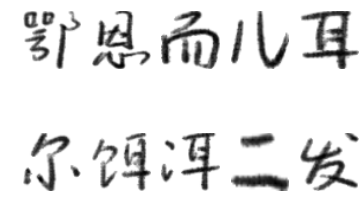

In [9]:
show_images(Xr)

### Иероглифы из тестовой выборки

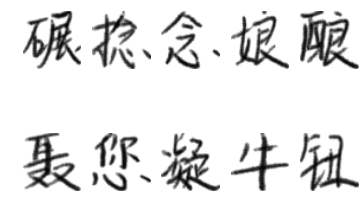

In [10]:
show_images(Xr_test)

### Применим преобразование которое "расширит" яркие пиксели картинок

In [11]:
import cv2

def dilate(X):
    return cv2.dilate(X.reshape(h, w), np.ones((2, 2))).reshape(1, h, w)

### Картинки после преобразования

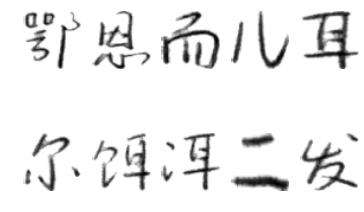

In [12]:
show_images(Xr, dilate)

## Разбиваем данные на обучающую и тестовую выборки

In [13]:
import random
from copy import deepcopy

random.seed(17)
    
n_classes = 2000

def shuffle(a, b):
    indexes = range(len(a))
    random.shuffle(indexes)
    a[:] = a[indexes]
    b[:] = b[indexes]

print("Shuffle data randomly")
shuffle(Xr, y)

Shuffle data randomly


#### Функция для вывода иероглифов определенного класса

In [14]:
def print_class(sample_num, X, y):
    fig = plt.figure()

    X3 = X[y == sample_num]

    for i in range(len(X3[:3])):
        plt.axis('off')
        plt.imshow(X3[i].reshape(h, w), cmap=plt.gray())
        plt.show()

### Для того чтобы сделать сбалансированное разбиение (stratified split) нам необходимо выделить объекты каждого класса

In [15]:
n_classes = 2000

print("Find class items")
class_items = [[] for i in range(n_classes)]

for i in range(len(y)):
    if y[i] < n_classes:
        class_items[y[i]].append(i)
    
class_items = np.array(class_items)

Find class items


### Делаем разбиение в пропорциях 90% train / 10% test

In [16]:
print("Making train test split")

test_ratio = 0.1

Xr_subset_train = []
Xr_subset_test = []
y_subset_train = []
y_subset_test = []

for i in range(n_classes):
    class_Xr = Xr[class_items[i]]
    class_y = y[class_items[i]]
    
    test_size = test_ratio * len(class_Xr)
    train_size = len(class_Xr) - test_size
    
    Xr_subset_train.append(class_Xr[:train_size])
    y_subset_train.append(class_y[:train_size])
    Xr_subset_test.append(class_Xr[train_size:])
    y_subset_test.append(class_y[train_size:])
    
Xr_subset_train = np.array(Xr_subset_train)
y_subset_train = np.array(y_subset_train)
Xr_subset_test = np.array(Xr_subset_test)
y_subset_test = np.array(y_subset_test)
    

Making train test split


### Превращаем картинки в четырехмерный тензор для входа в caffe

In [17]:
Xr_subset_train = Xr_subset_train.reshape(Xr_subset_train.shape[0] * Xr_subset_train.shape[1], 1, h, w)
Xr_subset_test = Xr_subset_test.reshape(Xr_subset_test.shape[0] * Xr_subset_test.shape[1], 1, h, w)
y_subset_train = y_subset_train.reshape(y_subset_train.shape[0] * y_subset_train.shape[1])
y_subset_test = y_subset_test.reshape(y_subset_test.shape[0] * y_subset_test.shape[1])

#### На всякий случай еще раз перемешиваем

In [18]:
shuffle(Xr_subset_train, y_subset_train)
shuffle(Xr_subset_test, y_subset_test)

In [19]:
print(Xr_subset_train.shape)
print(Xr_subset_test.shape)

(180000, 1, 50, 50)
(20000, 1, 50, 50)


### Расширяем обучающую выборку картинками после преобразования dilate

In [20]:
Xr_subset_dilated_train = np.array([dilate(x) for x in Xr_subset_train])
Xr_subset_dilated_test = np.array([dilate(x) for x in Xr_subset_test])

In [21]:
print(Xr_subset_dilated_train.shape)
print(Xr_subset_dilated_test.shape)

(180000, 1, 50, 50)
(20000, 1, 50, 50)


### Сохраняем картинки на диск в формате понятном caffe

In [22]:
import h5py

# Write out the data to HDF5 files in a temp directory.
dirname = os.path.abspath("classification/data/")
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train_' + str(h) + "_" + str(n_classes) + '.h5')
test_filename = os.path.join(dirname, 'test_' + str(h) + "_" + str(n_classes) + '.h5')
predict_filename = os.path.join(dirname, 'predict.h5')

print("Write train data")
with h5py.File(train_filename, 'w') as f:
    f.create_dataset('data', data=Xr_subset_train)
    f.create_dataset('label', data=y_subset_train.astype(np.float32))
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')

print("Write test data")
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xr_subset_test)
    f.create_dataset('label', data=y_subset_test.astype(np.float32))
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

Write train data
Write test data


### Сохраняем модифицированные картинки

In [23]:
import h5py

# Write out the data to HDF5 files in a temp directory.
dirname = os.path.abspath("classification/data/")
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train_dilated_' + str(h) + "_" + str(n_classes) + '.h5')
test_filename = os.path.join(dirname, 'test_dilated_' + str(h) + "_" + str(n_classes) + '.h5')

print("Write train data")
with h5py.File(train_filename, 'w') as f:
    f.create_dataset('data', data=Xr_subset_dilated_train)
    f.create_dataset('label', data=y_subset_train.astype(np.float32))
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')

print("Write test data")
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xr_subset_dilated_test)
    f.create_dataset('label', data=y_subset_test.astype(np.float32))
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

Write train data
Write test data


## Этап распознавания

### Загружаем обученную модель с диска

In [24]:
MODEL_FILE = 'classification/network/lenet/lenet.prototxt'
PRETRAINED = 'classification/network/lenet/data/train_iter_22000.caffemodel'

In [25]:
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED, image_dims=(50, 50))

### Прогоняем тестовые картинки через сеть

In [26]:
from copy import deepcopy

batch_size = 25
data_size = len(Xr_test)

predictions = []

for i in range((data_size + batch_size - 1) / batch_size):
    if i % 400 == 0:
        print("Processed: {}".format(i * batch_size))
    caffe_data =  np.array([x.reshape(1, h, w) for x in Xr_test[i * batch_size:min((i + 1) * batch_size, data_size)]])
    net.forward(data=caffe_data)
    prediction = net.blobs["prob"].data
    predictions.append(deepcopy(prediction))

Processed: 0
Processed: 10000
Processed: 20000
Processed: 30000
Processed: 40000
Processed: 50000
Processed: 60000
Processed: 70000
Processed: 80000
Processed: 90000
Processed: 100000
Processed: 110000
Processed: 120000
Processed: 130000
Processed: 140000
Processed: 150000
Processed: 160000
Processed: 170000
Processed: 180000
Processed: 190000


#### Распределение вероятностей по классам для одного тестового примера:

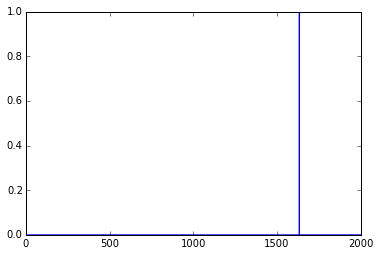

In [36]:
plt.plot(predictions[0][22])

#### Разворачиваем батчи и выбираем класс с максимальной вероятностью

In [37]:
y_predicted = np.array([x.argmax() for batch in predictions for x in batch])

#### Посчитаем распределение "степени уверенности в ответе"

(array([  1.53000000e+02,   8.58000000e+02,   2.23400000e+03,
          3.57200000e+03,   5.03200000e+03,   6.64200000e+03,
          6.47200000e+03,   7.29300000e+03,   1.04090000e+04,
          1.57335000e+05]),
 array([ 0.01646241,  0.11481617,  0.21316993,  0.31152369,  0.40987745,
         0.5082312 ,  0.60658496,  0.70493872,  0.80329248,  0.90164624,  1.        ]),
 <a list of 10 Patch objects>)

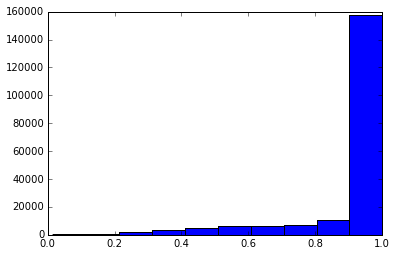

In [38]:
probs = np.array([x.max() for batch in predictions for x in batch])
hist(probs)

### Распределение меток в тестовой выборке

(array([ 1.,  0.,  0.,  4.,  2.,  1.,  4.,  5.,  3.,  5.]),
 array([  457. ,   610.7,   764.4,   918.1,  1071.8,  1225.5,  1379.2,
         1532.9,  1686.6,  1840.3,  1994. ]),
 <a list of 10 Patch objects>)

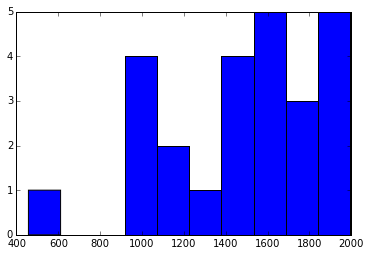

In [39]:
hist([y_predicted[i] for i in range(len(prediction))])

### Записываем результат предсказания в формате для kaggle

In [40]:
# Id,Prediction
# 0,1
# 1,0
# 2,10
# 3,1999
# etc.

with open("classification/predictions/prediction.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(len(y_predicted)):
        f.write("{},{}\n".format(i, y_predicted[i]))

### Визуализируем некоторые ответы на тестовые примеры

In [41]:
def print_error(sample_num):
    ans = np.arange(2000)[predictions[0][sample_num] > 0.3]
    
    fig = plt.figure()

    X3 = Xr_test[sample_num]

    for i in range(len(X3[:1])):
        plt.axis('off')
        plt.imshow(X3[i].reshape(h, w), cmap=plt.gray())
        plt.show()
    
    for ans_num in ans:
        fig = plt.figure()

        X3 = Xr[y == ans_num]

        for i in range(len(X3[:1])):
            plt.axis('off')
            plt.imshow(X3[i].reshape(h, w), cmap=plt.gray())
            plt.show()

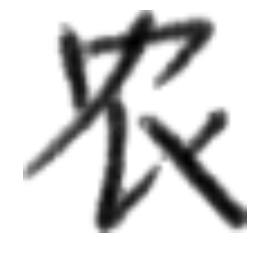

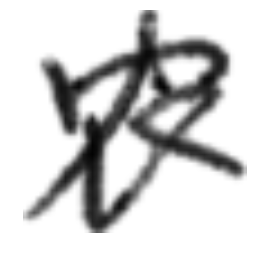

In [43]:
print_error(12)

### Применим метод semi-supervised learning
#### Будем дообучаться на тествых примерах, в метках которых мы уверены

In [44]:
idx = probs > 0.999

X_semi_train = Xr_test[idx]
y_semi_train = y_predicted[idx]

In [45]:
print(X_semi_train.shape)
print(y_semi_train.shape)

(95637, 1, 50, 50)
(95637,)


### Допишем их в обучающую выборку

In [46]:
import h5py

# Write out the data to HDF5 files in a temp directory.
dirname = os.path.abspath("classification/data/")
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train_semi_' + str(h) + "_" + str(n_classes) + '.h5')

print("Write train data")
with h5py.File(train_filename, 'w') as f:
    f.create_dataset('data', data=X_semi_train)
    f.create_dataset('label', data=y_semi_train.astype(np.float32))
with open(os.path.join(dirname, 'train.txt'), 'a') as f:
    f.write(train_filename + '\n')

Write train data


### Изучим "подозрительные" предсказания, в которых сеть не была уверена

In [48]:
suspicious = probs < 0.5

X_suspicious = Xr_test[suspicious]
y_suspicious = y_predicted[suspicious]
probs_suspicious = probs[suspicious]

In [49]:
print(X_suspicious.shape)
print(y_suspicious.shape)

(11275, 1, 50, 50)
(11275,)


In [50]:
def print_class_items(sample_num, X, y, count=100):
    fig = plt.figure()

    X3 = X[y == sample_num]

    for i in range(len(X3[:count])):
        plt.axis('off')
        plt.imshow(X3[i].reshape(h, w), cmap=plt.gray())
        plt.show()

def show_suspicious(id):
    fig = plt.figure()

    X3 = X_suspicious[id]
    print(probs_suspicious[id])
    print(y_suspicious[id])
    
    plt.axis('off')
    plt.imshow(X3.reshape(h, w), cmap=plt.gray())
    plt.show()
    
    print_class_items(y_suspicious[id], Xr_subset_test, y_subset_test, 3)
#     print_class_items(y_suspicious[id], Xr_test, y_orig, 3)
    pass

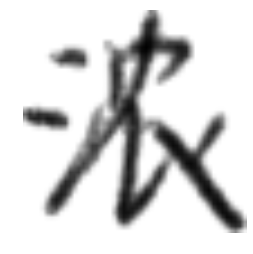

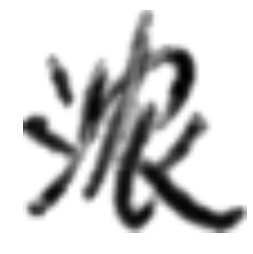

In [58]:
print_error(11)

0.392624
512


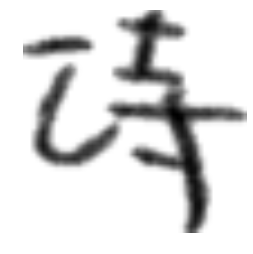

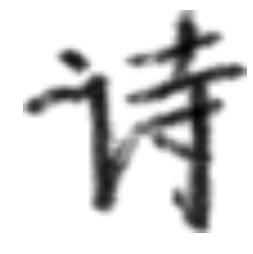

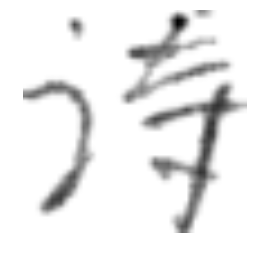

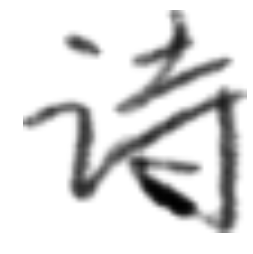

In [59]:
show_suspicious(24)